# Opis projektu i zbioru danych
W ramach projektu analizowany jest zbiór danych *World Happiness Report 2021* (Raport Szczęścia Świata 2021) dostępny na portalu Kaggle. Jest to zbiór dotyczący globalnych wyników szczęścia — czyli poziomu zadowolenia mieszkańców różnych krajów świata. Dane obejmują wyniki dla 149 krajów i zostały rozszerzone o informacje o regionach geograficznych.

Źródłem danych są coroczne raporty ONZ – *World Happiness Report*, przygotowywane we współpracy z instytutem **Gallupa** oraz **Sustainable Development Solutions Network**, oparte głównie na ankietach oceniających dobrostan i satysfakcję z życia w latach 2005–2020.

Główną analizowaną zmienną zależną jest **Life Ladder**, która określa poziom szczęścia mieszkańców danego kraju.

**Wybrane zmienne do analizy:**
* country – kraj
* region – region świata
* gdp_per_capita – PKB per capita (zamożność)
* social_support – poczucie wsparcia społecznego
* healthy_expectancy – spodziewana długość życia
* freedom – poczucie wolności
* generosity – poziom hojności
* corruption – postrzegana korupcja

Dodatkowo, analiza będzie dążyła do odpowiedzi na następujące pytania:
1. Które czynniki (np. PKB, wsparcie społeczne, długość życia) mają najsilniejszy związek z poziomem szczęścia?
2. Czy istnieją istotne różnice w poziomie szczęścia między regionami świata (np. Europa Zachodnia vs. Afryka Subsaharyjska)?
3. Czy najbogatsze kraje są rzeczywiście najszczęśliwsze? A może inne czynniki (np. wolność, brak korupcji) są równie istotne?
4. Które kraje odstają od trendów, czyli np. mają wysokie PKB i niski poziom szczęścia lub odwrotnie — dlaczego?

Celem projektu jest zbadanie zależności między poziomem szczęścia (Life Ladder), a czynnikami ekonomicznymi i społecznymi — z uwzględnieniem regionów i lat.

In [43]:
# Importy i wczytanie danych
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [44]:
# wykresy w notebooku oraz ich jakość
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [74]:
# wczytanie dataseta i sprawdzenie czy jest wczytany poprawnie
df = pd.read_csv('../data/world-happiness-report.csv')
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [75]:
# dodanie regionów do df oraz zmiana nazwy kolumn
region_map = pd.read_csv("../data/country-region-mapping.csv")
region_map = region_map.drop_duplicates()
df = df.merge(region_map, on="Country name", how="left")

df.rename(columns={'Country name': 'country'}, inplace=True)
df.rename(columns={'Life Ladder': 'life_ladder'}, inplace=True)
df.rename(columns={'Log GDP per capita' : 'gdp_per_capita'}, inplace=True)
df.rename(columns={'Social support': 'social_support'}, inplace=True)
df.rename(columns={'Healthy life expectancy at birth': 'healthy_expectancy'}, inplace=True)
df.rename(columns={'Freedom to make life choices': 'freedom'}, inplace=True)
df.rename(columns={'Generosity': 'generosity'}, inplace=True)
df.rename(columns={'Perceptions of corruption': 'corruption'}, inplace=True)
df.rename(columns={'Positive affect': 'positive_affect'}, inplace=True)
df.rename(columns={'Negative affect': 'negative_affect'}, inplace=True)
df.rename(columns={'Region': 'region'}, inplace=True)

df.head()

,country,year,life_ladder,gdp_per_capita,social_support,healthy_expectancy,freedom,generosity,corruption,positive_affect,negative_affect,region
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,Southern Asia
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,Southern Asia
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,Southern Asia
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,Southern Asia
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,Southern Asia


In [76]:
# Sprawdzam ilość brakujących wartości w kolumnach
df_summary = pd.DataFrame({    
    "Null Count": df.isnull().sum(),
    "Dtype": df.dtypes
}).sort_values("Null Count", ascending=False)
df_summary

,Null Count,Dtype
corruption,110,float64
generosity,89,float64
healthy_expectancy,55,float64
gdp_per_capita,36,float64
freedom,32,float64
positive_affect,22,float64
negative_affect,16,float64
social_support,13,float64
country,0,object
year,0,int64


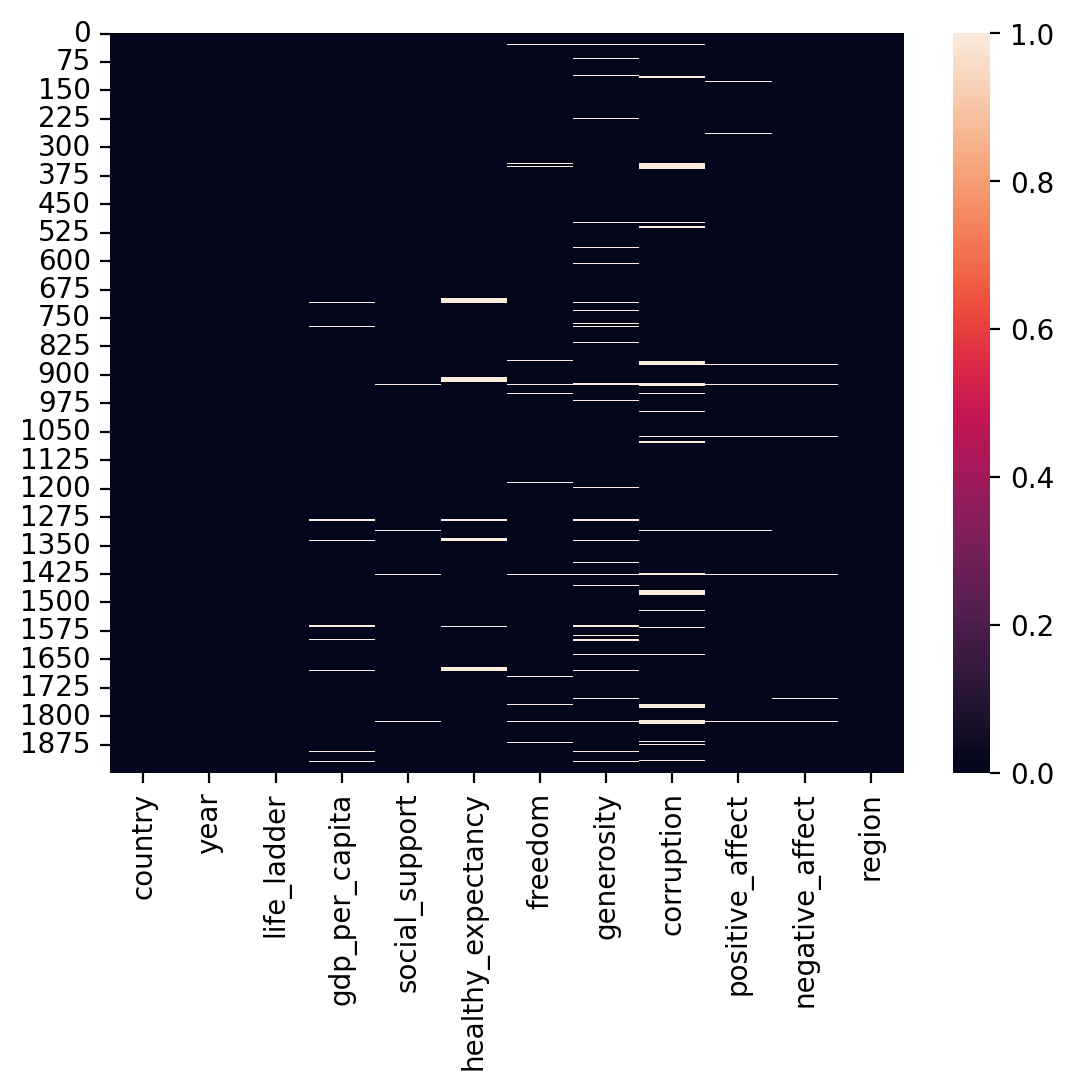

In [61]:
sns.heatmap(df.isna());

Braki występują w 9 z 12 kolumn. Najwięcej braków zaobserwowano w kolumnie *corruption* (110), a także w **generosity**, **healthy_expectancy**, **gdp_per_capita** oraz **freedom**. Kolumny **country**, **year**, **life_ladder** oraz **region** są kompletne. Powyższa heatmapa prezentuje rozmieszczenie braków w danych.. Można zauważyć, że braki nie są rozmieszczone równomiernie – ich skupiska pojawiają się w określonych obszarach (prawdopodobnie konkretnych latach lub regionach), co zostanie przeanalizowane w kolejnych krokach.
Zauważono również, że w danych występują obserwacje z kilkoma pustymi wartościami w kolumnach. Zdecydowano o usunięciu takich, w których jest więcej niż 2.

In [82]:
# usuwam wiersze z brakującymi wartościami, gdzie jest więcej niż 2 brakujące wartości
df = df.dropna(thresh=df.shape[1] - 2) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1919 entries, 0 to 1948
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             1919 non-null   object 
 1   year                1919 non-null   int64  
 2   life_ladder         1919 non-null   float64
 3   gdp_per_capita      1902 non-null   float64
 4   social_support      1916 non-null   float64
 5   healthy_expectancy  1883 non-null   float64
 6   freedom             1894 non-null   float64
 7   generosity          1854 non-null   float64
 8   corruption          1919 non-null   float64
 9   positive_affect     1908 non-null   float64
 10  negative_affect     1913 non-null   float64
 11  region              1919 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 194.9+ KB


W pierwszej kolejności poddano analizie kolumne 'corruption'.

In [83]:
# braki w 'corruption' wg. lat
df[df['corruption'].isnull()]['year'].value_counts()

Series([], Name: count, dtype: int64)

In [84]:
# braki w 'corruption' wg regionów
df[df['corruption'].isnull()]['region'].value_counts()

Series([], Name: count, dtype: int64)

Braki danych w kolumnie 'corruption' rozkładają się w miarę równomiernie w latach. Natomiast zdecydowanie najwięcej NaN wystepuje w regionie Middle East and Northern Africa. Postawowiono uzupełnić wartości medianą w obrębie każdego z regionów.

In [85]:
# wypełnienie NaN w kolumnie 'corruption' medianów z regionów w danym roku
df['corruption'] = df.groupby(['region', 'year'])['corruption'].transform(
    lambda x: x.fillna(x.median())
)
df['corruption'].isnull().sum()

0

In [ ]:
# do testów - wywalenia
# wszystkie braki sumarycznie dla poszczególnych krajów
df[df.isnull().any(axis=1)]['country'].value_counts()
missing_by_country = df.groupby('country').apply(lambda x: x.isnull().sum().sum()).sort_values(ascending=False)
print(missing_by_country.head(10))

country
Kosovo                       12
Hong Kong S.A.R. of China    10
Jordan                        9
South Sudan                   8
Palestinian Territories       8
Iran                          8
Taiwan Province of China      7
Venezuela                     7
Somalia                       6
China                         6
dtype: int64


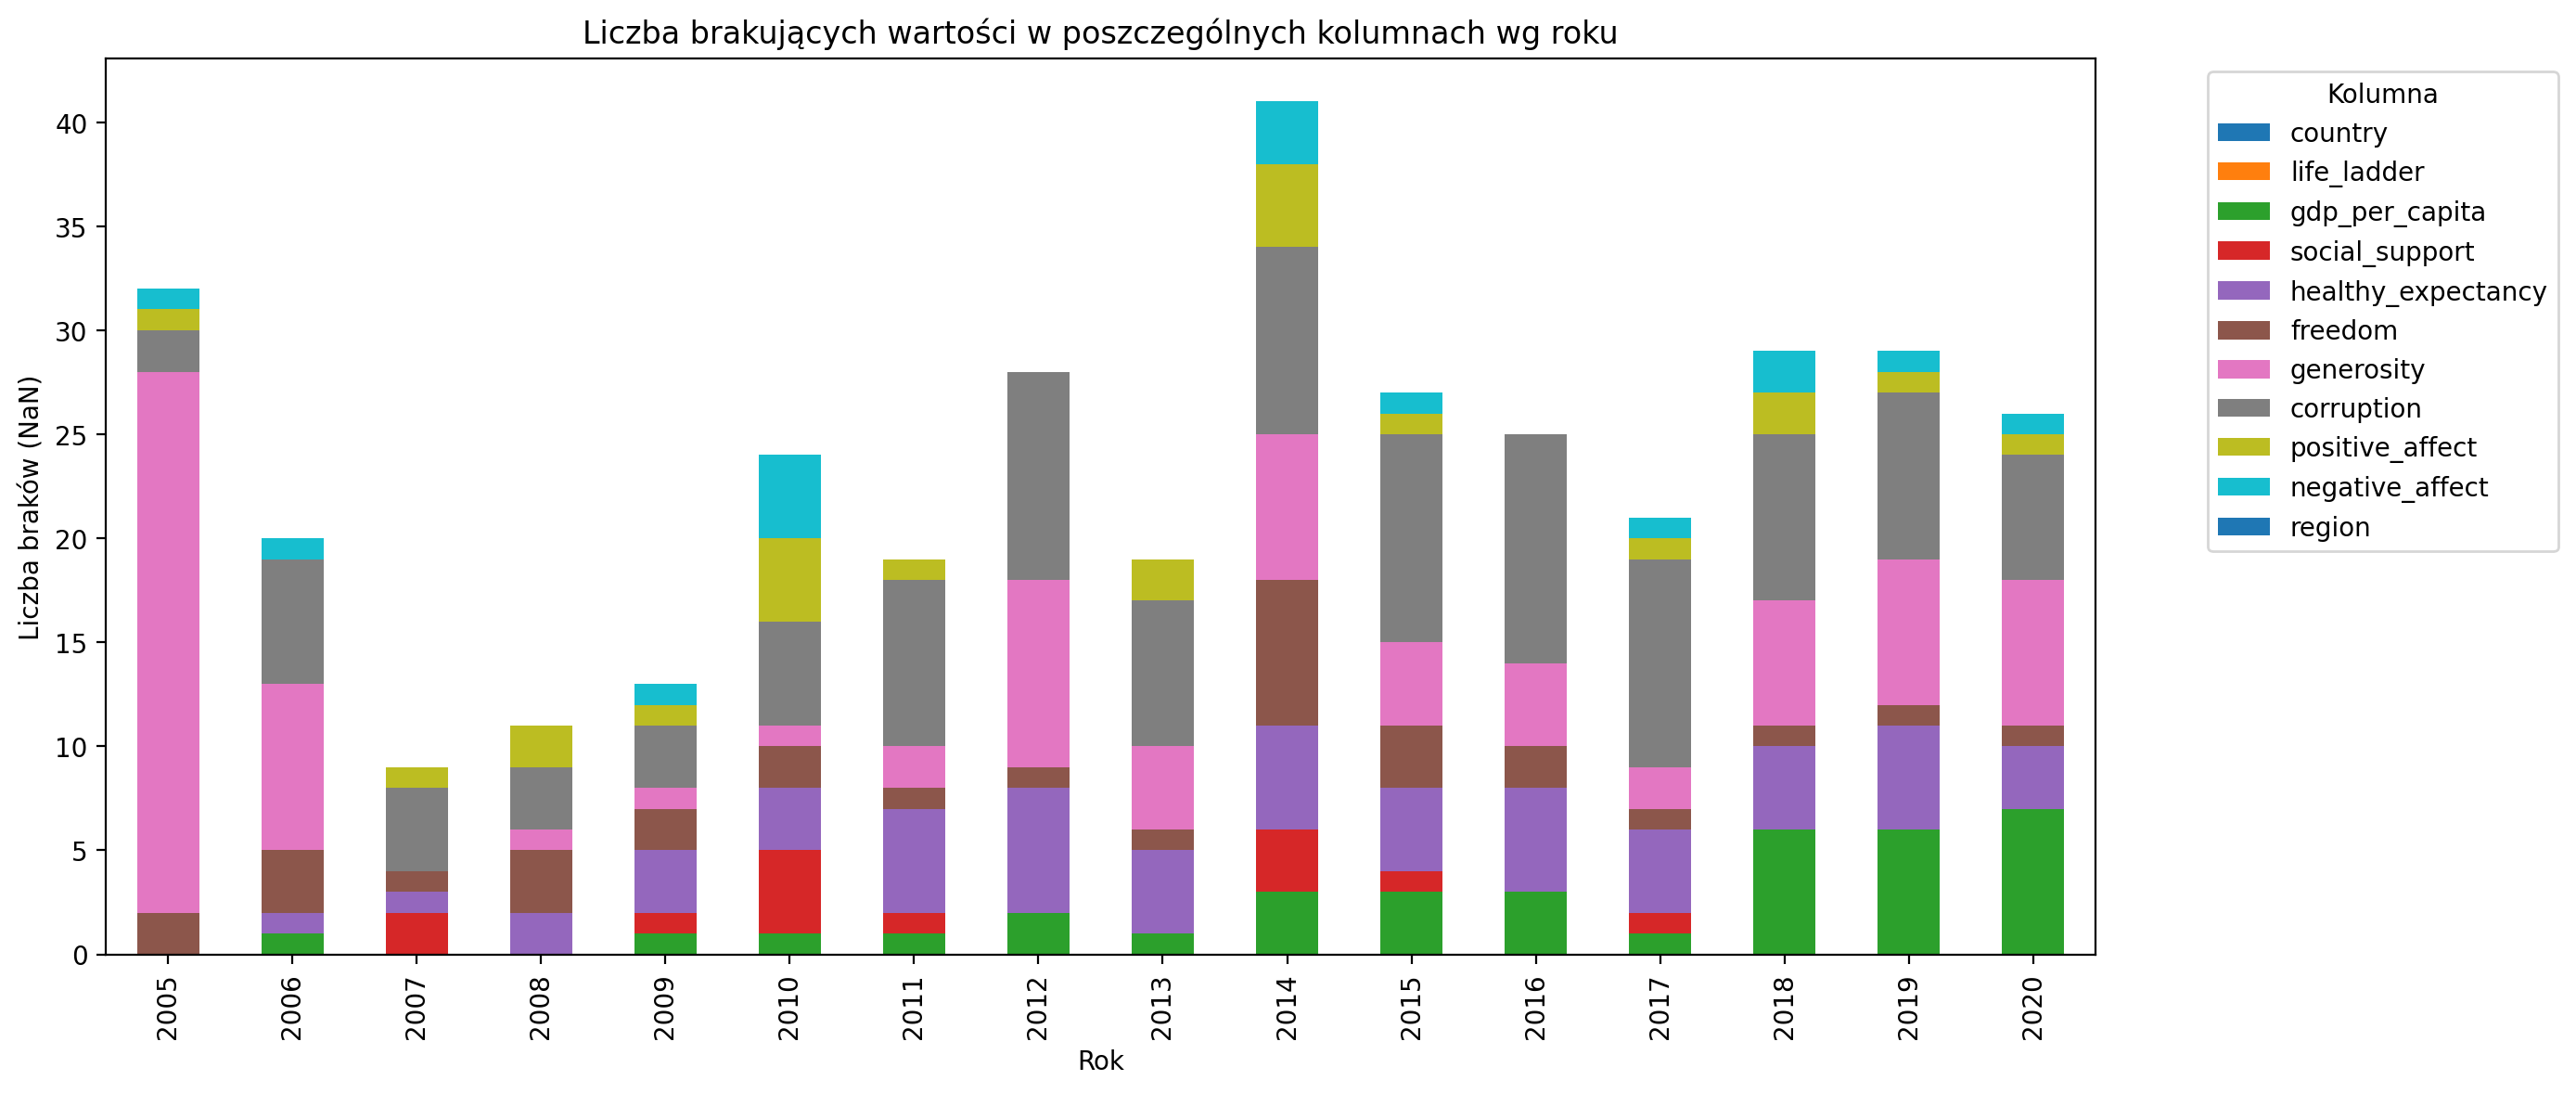

In [ ]:
# do testów - wywalenia
# Tworzymy tabelę: liczba braków (NaN) w każdej kolumnie dla każdego roku
missing_by_year_col = df.groupby('year').apply(lambda g: g.isnull().sum()).drop(columns=['year'])

# Wykres słupkowy: lata na osi X, kolumny z brakami jako różne kolory
missing_by_year_col.plot(kind='bar', stacked=True, figsize=(14, 6))

plt.title('Liczba brakujących wartości w poszczególnych kolumnach wg roku')
plt.ylabel('Liczba braków (NaN)')
plt.xlabel('Rok')
plt.legend(title='Kolumna', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: >

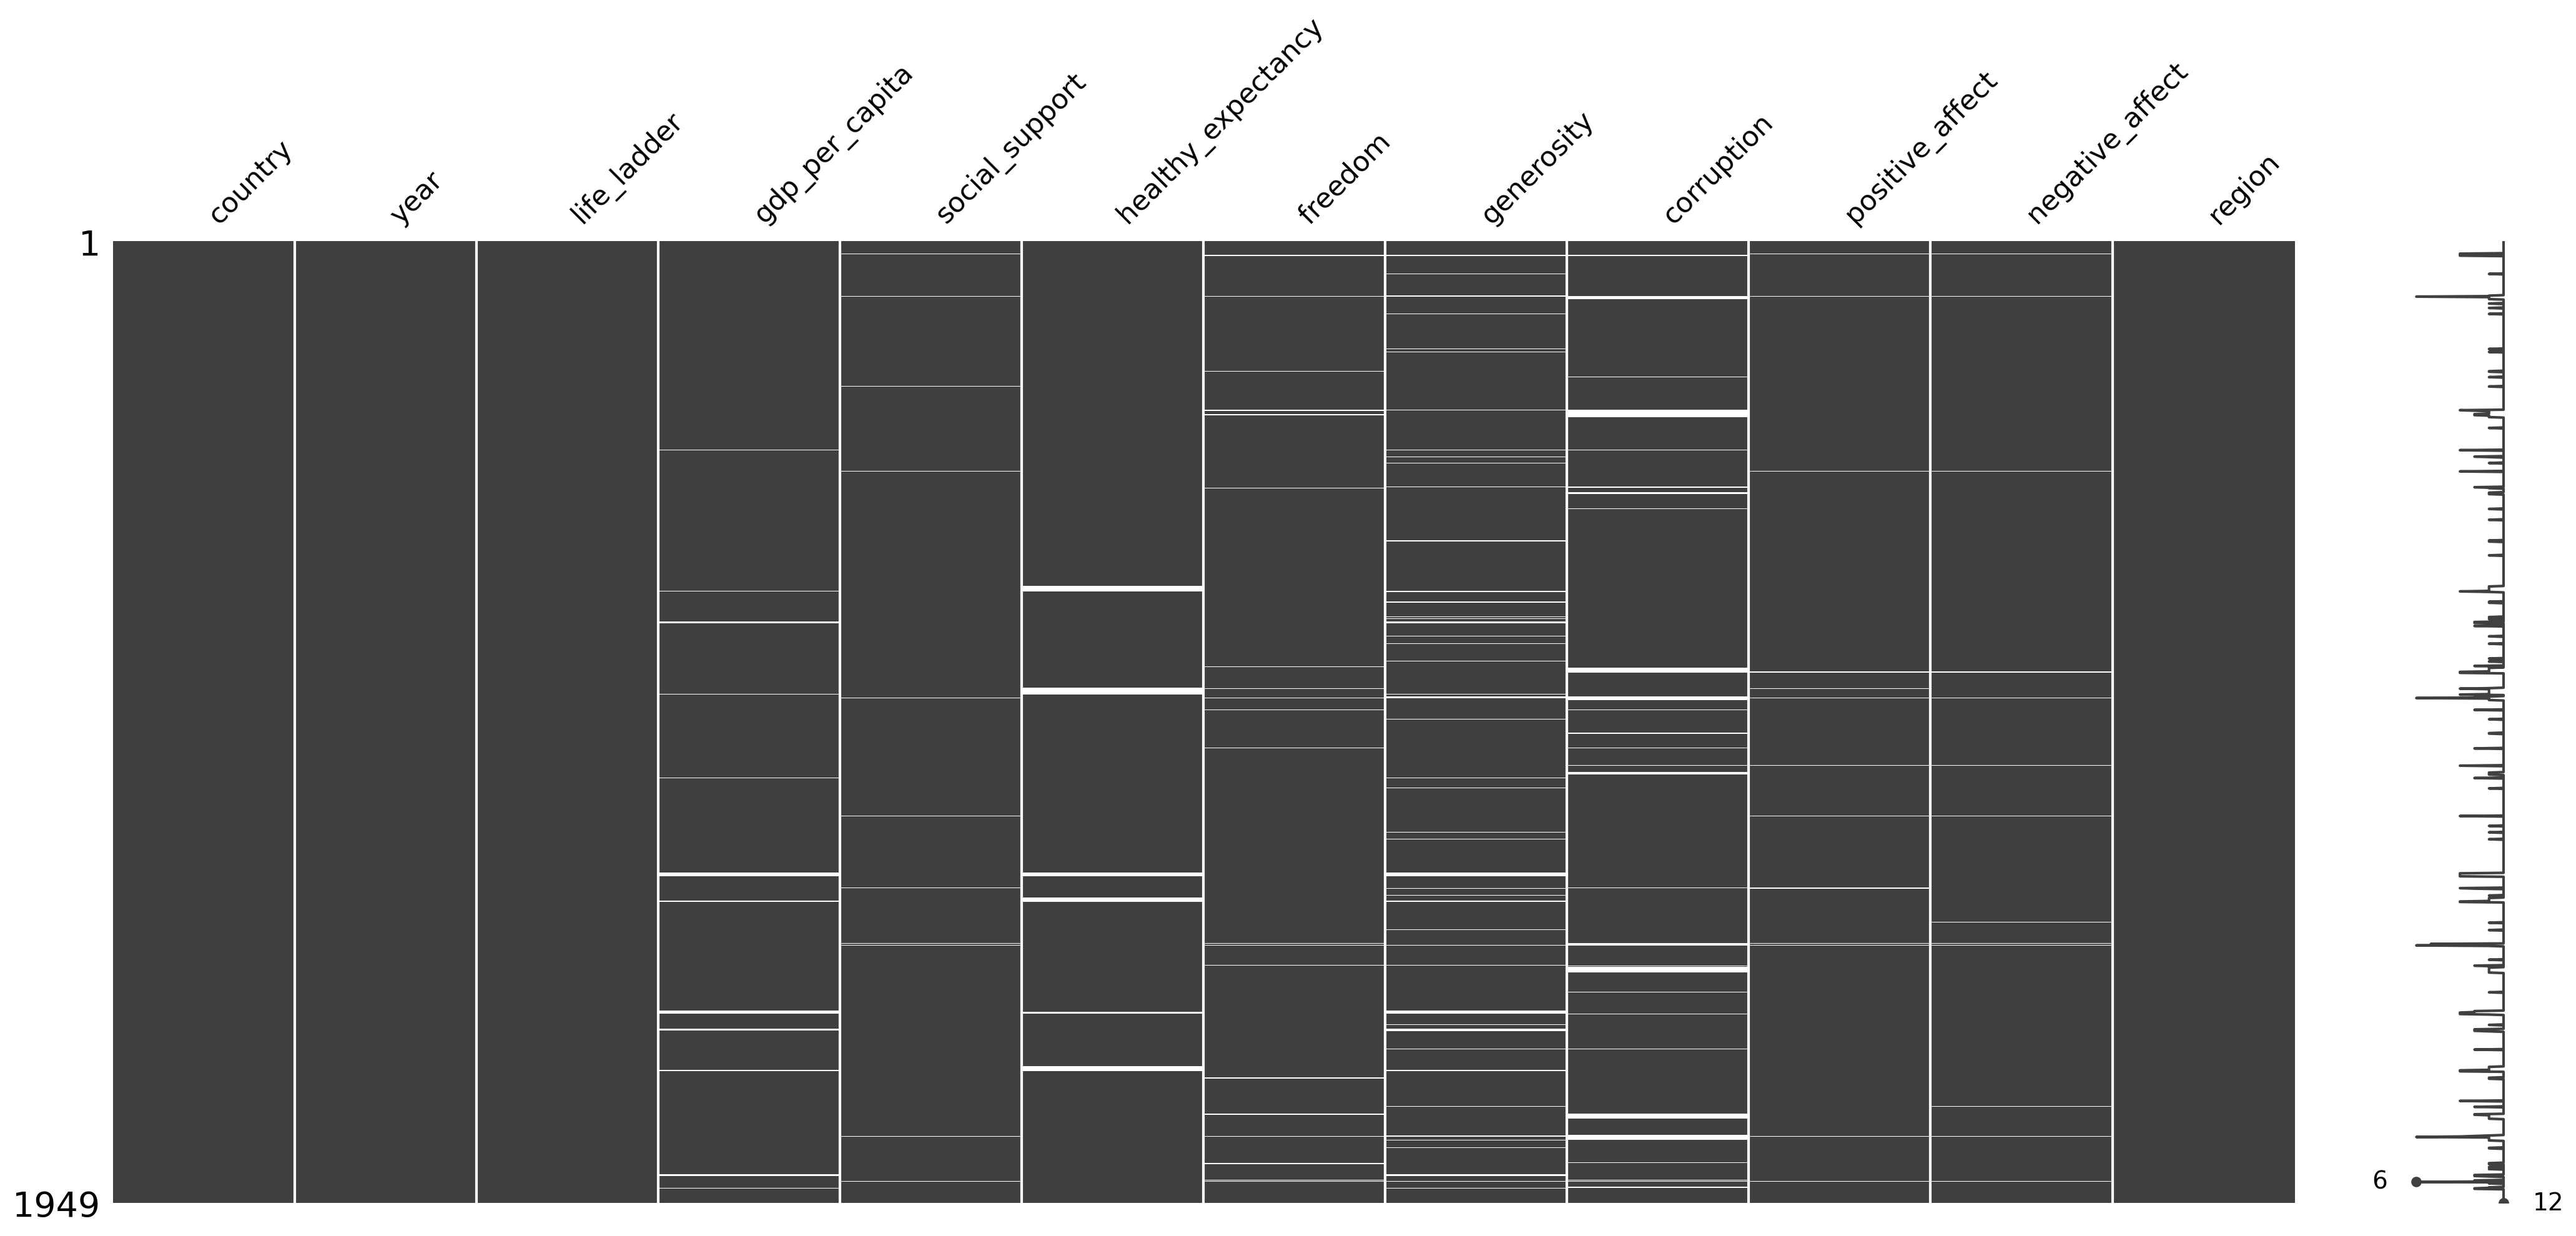

In [ ]:
# do testów - wywalenia
import missingno as msno
msno.matrix(df)

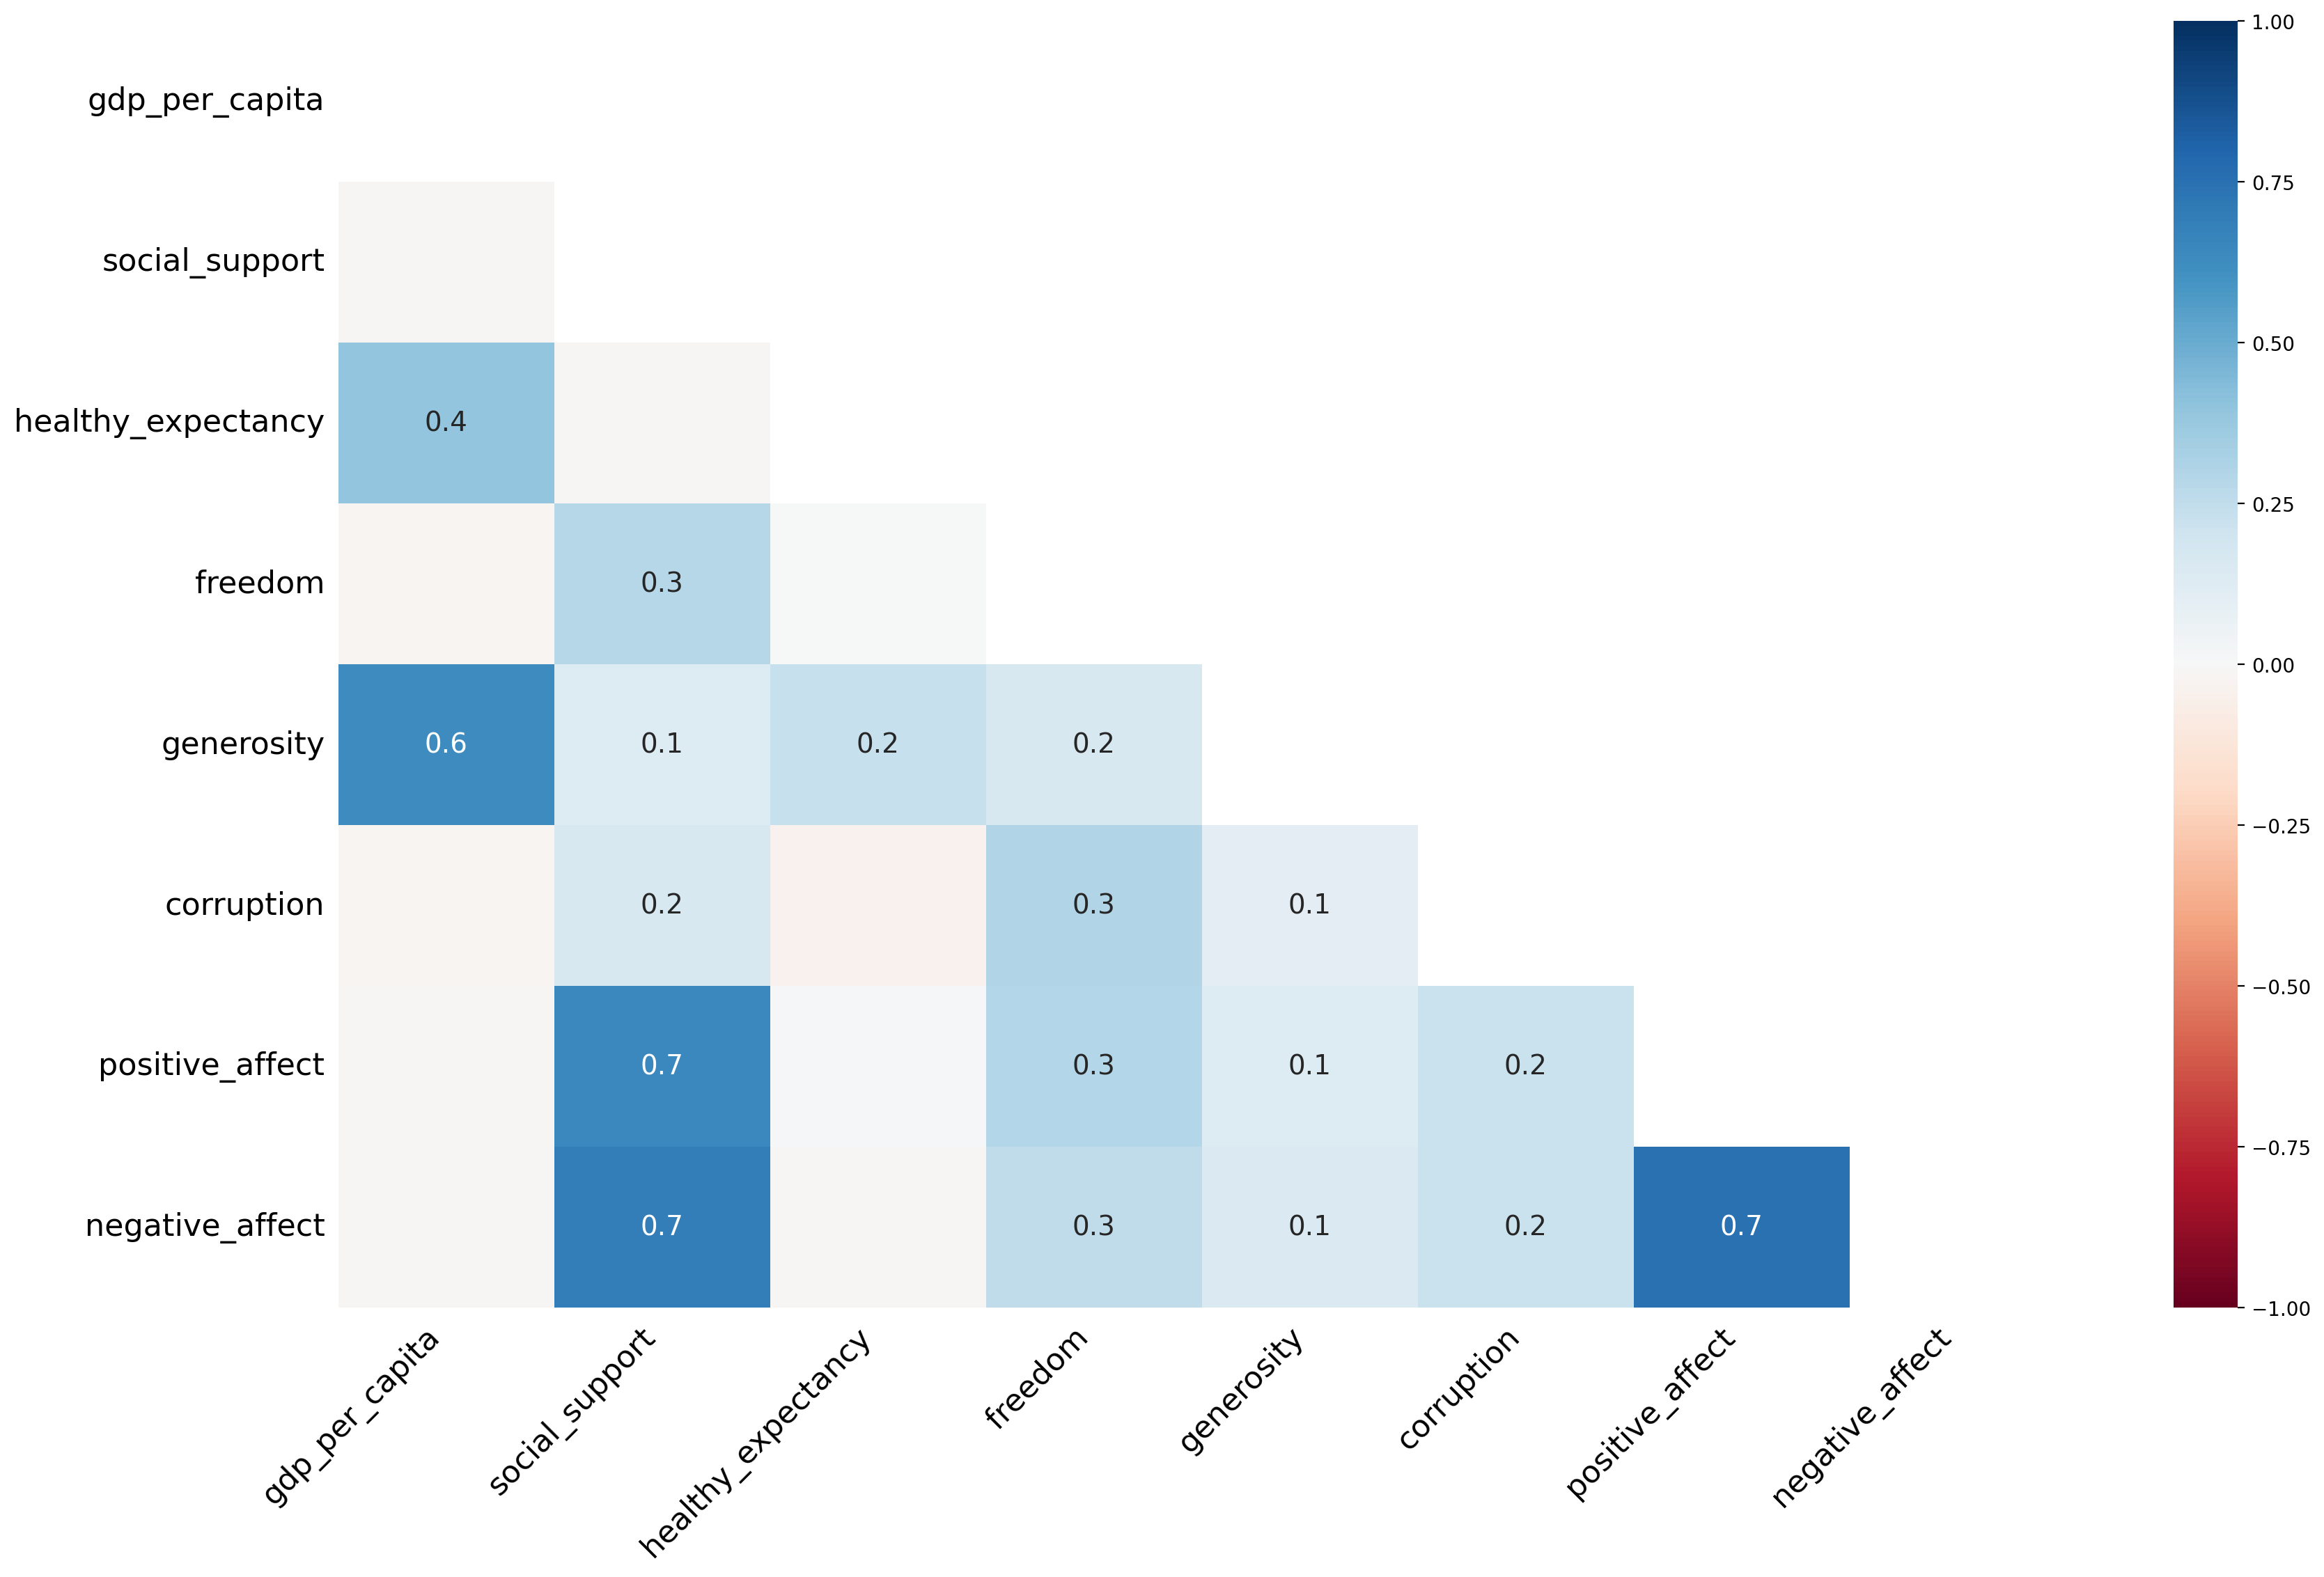

In [ ]:
# do testów - wywalenia?
msno.heatmap(df);

In [ ]:
# zapisuje oczyszczony DataFrame do pliku CSV
df_cleaned = df
df_cleaned.to_csv('../data/happiness_cleaned.csv', index=False)